In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [2]:
# Use this cell to regroup all your imports

from scipy import stats

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

## Load

In [3]:
data = pd.read_csv("data-houseprice.csv")
data

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
X = data.drop(columns=['SalePrice','Id'])
y = data.SalePrice
X.shape

(1460, 80)

# 🐣 BASELINE

## Initial feature overview

¡80 características es demasiado para lidiar con una por una para una primera línea de base! Vamos a tratarlos únicamente en función de su tipo:

¿Cuántas características numéricas frente a características categóricas tenemos?

In [5]:
X.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

❓ Almacene la serie feat_categorical_nunique que contiene el número de valores únicos para cada característica categórica en nuestro conjunto de entrenamiento. ¿Cuántas categorías únicas hay en total?

In [6]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()

In [7]:
feat_categorical_nunique.sum()

252

🤔 Si tuviéramos que OneHotEncode todas las características categóricas, nuestra matriz de características X_preproc sería bastante grande y sobria, con casi 300 características (altamente correlacionadas) para solo 1400 observaciones. Idealmente, deberíamos apuntar a alimentar nuestro modelo con 50-100 características como máximo (📚 )

Existen 2 estrategias principales para reducir la cantidad de características categóricas posteriores al preprocesamiento: Elimina las características que aportan muy poca explicación a nuestro modelo. Esto puede requerir un análisis estadístico de la importancia de la característica. Codifique ordinalmente (en lugar de codificación única) características categóricas en números enteros. Sin embargo, esto fuerza una noción de "orden" (1> 2> 3 ...) que puede ser perjudicial si no se configura correctamente.

❓histograma de número de valor único por característica categórica. ¿Ves algunas victorias rápidas?

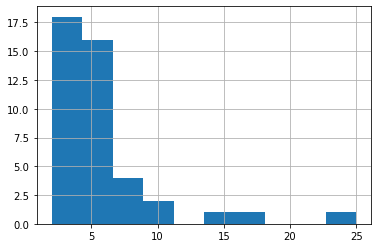

In [8]:
feat_categorical_nunique.hist();

In [9]:
# categorical features to one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)

In [10]:
len(feat_categorical_small)

34

## Preprocessing pipeline - V1 minimal baseline

In [11]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler())

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop")

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000015805A419D0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown=...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

❓ Look at the **shape** of your preprocessed dataframe.

In [12]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(1460, 184)

## Model baseline

 ❓ Pipe a basic Ridge regressor to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [13]:
pipe_baseline = make_pipeline(preproc_baseline, Ridge())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015805A419D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehote...
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('ridge', Ridge())])

In [14]:
def root_mean_squared_log_error(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)
    log_error = np.log(1+t) - np.log(1+p)
    return ((log_error**2).mean())**0.5

# This is our metric to minimize
rmsle = make_scorer(root_mean_squared_log_error)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * root_mean_squared_log_error(y_true, y_pred))

In [15]:
# OPTION 2 - reuse sklearn "mean_squared_log_error"
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)
# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)

❓Validé 5 veces su pipe_baseline utilizando esta métrica para obtener un primer vistazo a su rendimiento de línea de base. Almacene su puntuación media como score_baseline

In [16]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.16631913339626236

## Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [102]:
X_test = pd.read_csv("data-houseprice.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id','SalePrice'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

array([213079.06344305, 200790.08275845, 220935.83646195, ...,
       242119.60724482, 158283.51096824, 154869.09095094])

In [104]:
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head()

,Id,SalePrice
0,1,213079.063443
1,2,200790.082758
2,3,220935.836462
3,4,173216.631334
4,5,270744.498116


🧪 Test your code

# 🏋️‍♀️ ITERATIONS 

### Ordinal Encoding

❓ 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 

In [25]:
# Nota: si cambia este orden, cambiará la salida para .transform ()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 2.,  2.],
       [ 0., -1.]])

---
❓ **Aqui**: divide tu preprocesador categórico en

- `preproc_ordinal` para codificar ordinalmente algunas características de su elección (primero haga una iteración rápida)
- `preproc_nominal` to one hot encode the other ones


In [26]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [27]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [28]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [29]:
preproc = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000015805A73A60>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(cat...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [30]:
preproc.fit_transform(X).shape

(1460, 217)

### Target engineering


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

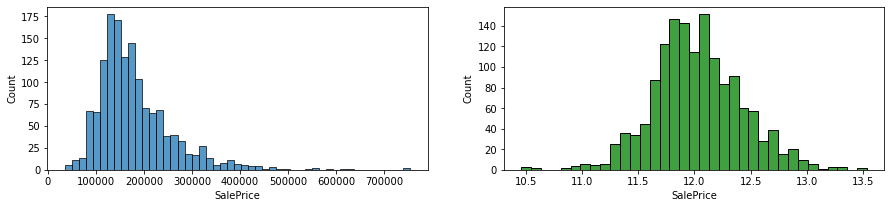

In [31]:
y_log = np.log(y)
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.histplot(y)
plt.subplot(1,2,2)
sns.histplot(y_log, color='green')

In [32]:
# Create your new scorer to minimize
from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

### Statistical Feature Selection 

Mi objetivo es eliminar las características menos interesantes, limitar el sobreajuste y acortar el tiempo de entrenamiento. 

####  univariate feature selection based on relationship with target `y`

In [33]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only 50% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015805A739A0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'))...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x0000015805DD40D0>))])

In [34]:
preproc.fit_transform(X,y_log).shape

(1460, 108)

❓ la correlación de Pearson combinada con un mapa de calor ... 
- para comprobar visualmente si algunas características numéricas explican casi por completo otras. 
- Luego, cree un "filtro" en su canalización que elimine cualquier correlación por debajo de un cierto umbral

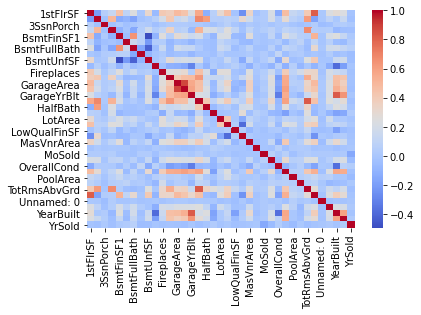

In [35]:
corr_num = X[feat_numerical].corr()
sns.heatmap(corr_num, cmap='coolwarm');

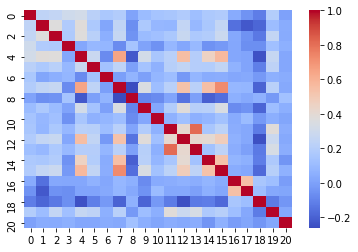

In [36]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))
sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm');

❓ Otra forma de filtrar la característica se basa únicamente en eliminar aquellas con la variación más baja. una característica que solo toma un valor es inútil (y tiene una varianza de 0). Intente agregar un VarianceThreshold al final de su canalización

Text(0.5, 1.0, 'Number of Feature Remaining')

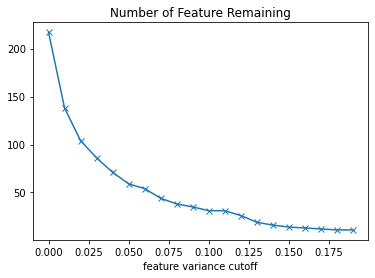

In [37]:
from sklearn.feature_selection import VarianceThreshold

def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop")

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector)

    return preproc.fit_transform(X).shape[1]

cutoff_values = np.arange(0, 0.2, 0.01)
plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')
plt.xlabel("feature variance cutoff")
plt.title("Number of Feature Remaining")

 ☝️  Podríamos decidir poner un threshold de 0.025 en las características categóricas para dividir su número por más de la mitad.

### Final preproc pipeline


In [38]:
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=75, # keep only 75% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001580A9E51F0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'))...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x0000015805DD40D0>))])

In [39]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)
preproc_fitted_log.transform(X).shape

(1460, 162)

In [78]:
preproc.fit_transform(X, y_log)

array([[0.23529412, 0.15068493, 0.0334198 , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.20205479, 0.03879502, ..., 1.        , 1.        ,
        1.        ],
       [0.23529412, 0.1609589 , 0.04650728, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.29411765, 0.15410959, 0.03618687, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.1609589 , 0.03934189, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.18493151, 0.04037019, ..., 1.        , 1.        ,
        1.        ]])

In [42]:
# # TODO: treat cyclical features
# feat_cyclical = sorted([
#     "MoSold"  # Month Sold (MM)
# ])

## Models Iteration

In [79]:
# SOLUTION
allow_grid_searching = False # use True to activate girdsearch in the notebook cells below

# Cache the preprocessing step of the pipeline
from tempfile import mkdtemp
from shutil import rmtree
cachedir = mkdtemp()

### Linear Models (Lasso, Ridge, ElasticNet, SGDRegressor...)

In [80]:
# Ridge with normal target
model = Ridge()
pipe_ridge = make_pipeline(preproc, model, memory=cachedir)
cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()

0.16079277085558016

In [81]:
# Rige with log-target (much better)
model = Ridge()
pipe_ridge = make_pipeline(preproc, model, memory=cachedir)
cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()

0.13930587782610662

In [82]:
# GridSearch the Ridge regularization
if allow_grid_searching:
    param_grid =  {'ridge__alpha': np.linspace(0.5,2,num=20)}
    search_ridge = GridSearchCV(pipe_ridge, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

    search_ridge.fit(X, y_log);
    print(search_ridge.best_params_)
    search_ridge.best_score_

### KNN

In [83]:
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)

In [84]:
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse)
scores.mean()

0.20503733814578187

In [85]:
# GridSearch the KNN
if allow_grid_searching:
    param_grid =  {'kneighborsregressor__n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
    search_knn = GridSearchCV(pipe_knn, param_grid=param_grid, 
                              cv=3, n_jobs=-1, verbose=2, scoring=rmse_neg)

    search_knn.fit(X, y_log);
    print(search_knn.best_params_)
    search_knn.best_score_

### SVM

In [86]:
model = SVR(kernel='linear')
pipe_svm = make_pipeline(preproc, model, memory=cachedir)
cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()

0.13946647908107146

In [87]:
model = SVR(kernel='rbf', C = 10)
pipe_svm_rbf = make_pipeline(preproc, model, memory=cachedir)
cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()

0.13350025918400008

In [88]:
# GridSearch
if allow_grid_searching:
    param_grid =  {'svr__C': [0.5, 0.7, 1, 2, 5, 10],
                  'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
                   #'svr__coef0': [0.0, 0.1, 0.5,1],
                  }
    search_svm_rbf = GridSearchCV(pipe_svm_rbf, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

    search_svm_rbf.fit(X, y_log);
    svm_rbf_best = search_svm_rbf.best_estimator_
    print(search_svm_rbf.best_params_)
    search_svm_rbf.best_score_

### Trees

In [89]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
pipe = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.010016067824884511


0.18862469199207105

### Random Forest

In [90]:

# TODO: GridSearch

model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)
pipe = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.007617245748559793


0.16243047508959702

### Boosted Trees

In [91]:
model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.00807185384570488


0.1419185099724211

In [92]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)
pipe_gb = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.009765093896620265


0.12555196733456994

In [93]:
if allow_grid_searching:
    grid = {
         'gradientboostingregressor__n_estimators': stats.uniform(50,300),
    #     'gradientboostingregressor__learning_rate':stats.uniform(0.05,0.3),
    #     'gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    #    'gradientboostingregressor__max_depth': stats.randint(3,5),    
    #    'gradientboostingregressor__min_samples_split':stats.randint(2,10),
    #    'gradientboostingregressor__subsample':[0.95, 1], # 1 default
         'gradientboostingregressor__max_features':stats.uniform(0.7,1), # default None, i.e = n_features
    }

    search_gb = RandomizedSearchCV(pipe_gb, grid, scoring=rmse_neg, n_iter=8, cv=5, n_jobs=1, verbose=2,)

    # Fit data to Grid Search
    search_gb.fit(X, y_log);
    print(search_gb.best_params_)
    search_gb.best_score_
    
    # Plot results of gridsearch
    df_cv_results_ = pd.DataFrame(search_gb.cv_results_)
    sns.scatterplot(x="param_gradientboostingregressor__n_estimators", y='mean_test_score', data=df_cv_results_)
    sns.scatterplot(x="param_gradientboostingregressor__max_features", y='mean_test_score', data=df_cv_results_)

### Stacking

In [94]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))


model = VotingRegressor(
    estimators = [("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm_rbf", svm)],
    weights = [1,1,1,1], # to equally weight the two models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

0.011212568711549081


0.11891308255330071

In [95]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm_rbf", svm)],
    
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

0.01094084498591597


0.11833084774891864

### XGBOOST

In [96]:
!pip install xgboost
from xgboost import XGBRegressor

In [97]:
# Create eval test just for early stopping purpose (XGBOOST and Deep Learning)
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X,y_log,random_state=42)

In [98]:
# Instanciate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)

In [99]:
# Option 1: Integrate XGB into Sklearn's pipeline
# It allows to GridSearchCV its best hyperparams
pipe_xgb = make_pipeline(preproc, model_xgb)
cross_val_score(pipe_xgb,X,y_log,cv=5,scoring=rmse,n_jobs=-1).mean()

0.13105210036276232

Best Validation Score 0.14228


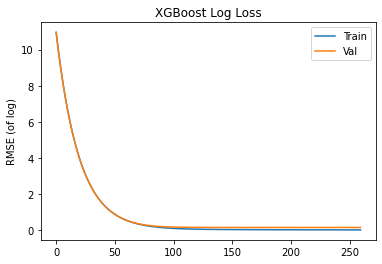

In [100]:
# Option 2: Use XGBoost Library to fit it
# It allows to use an early_stopping criteria with a Train/Val slit
X_train_preproc = preproc.fit_transform(X_train, y_train_log)
X_eval_preproc = preproc.transform(X_eval)

model_xgb.fit(X_train_preproc, y_train_log,
        verbose=False,
        eval_set=[(X_train_preproc, y_train_log), (X_eval_preproc, y_eval_log)],
        eval_metric=["rmse"],
        early_stopping_rounds=10)

# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']["rmse"])
x_axis = range(0, epochs)

# plot rmsle loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend(); plt.ylabel('RMSE (of log)'); plt.title('XGBoost Log Loss')

print("Best Validation Score", min(results['validation_1']['rmse']))

### Deep Learning